In [25]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType
from pyspark.sql.window import Window

In [26]:
# Define paths
silver_transactions_path = "/app/datamart/silver/transactions" 
silver_latest_transactions_path = "/app/datamart/silver/max_expiry_transactions"
gold_max_expiry_path = "/app/datamart/gold/label_store"

In [27]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

In [28]:
# Load all Silver parquet files
df_silver = spark.read.parquet(silver_transactions_path)
print("Silver Transactions schema:")
df_silver.printSchema()

Silver Transactions schema:
root
 |-- msno: string (nullable = true)
 |-- payment_method_id: integer (nullable = true)
 |-- payment_plan_days: integer (nullable = true)
 |-- plan_list_price: integer (nullable = true)
 |-- actual_amount_paid: integer (nullable = true)
 |-- is_auto_renew: integer (nullable = true)
 |-- transaction_date: date (nullable = true)
 |-- membership_expire_date: date (nullable = true)
 |-- is_cancel: integer (nullable = true)
 |-- source_file: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- transaction_id: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)



## Read silver/transactions

In [29]:
txn = (spark.read
      .option("header", True)
      .option("inferSchema", True)
      .parquet(silver_transactions_path))

## Get the transaction with latest expiry date per msno

In [31]:
# Ensure date types
txn = (
    txn.withColumn("transaction_date", F.to_date("transaction_date"))
       .withColumn("membership_expire_date", F.to_date("membership_expire_date"))
)

# 2) Build daily snapshot dates from 2015-02-01 to 2017-03-01 (inclusive)
snapshots = (
    spark.range(1)
         .select(
             F.explode(
                 F.sequence(
                     F.to_date(F.lit("2015-02-01")),
                     F.to_date(F.lit("2017-03-01")),
                     F.expr("interval 1 day")
                 )
             ).alias("snapshot_date")
         )
)

# Optional: if you specifically want *daily* snapshots, change interval to "interval 1 day".

# Cartesian over distinct users × snapshot dates
msnos = txn.select("msno").distinct()
grid = msnos.crossJoin(snapshots)

# 3) For each (msno, snapshot_date), find the latest membership_expire_date on/before the snapshot
#    (Using <=; switch to < if you truly need "strictly before".)
candidates = (
    grid.join(txn, on="msno", how="left")
        .where(
            F.col("membership_expire_date").isNotNull()
            & (F.col("membership_expire_date") <= F.col("snapshot_date"))
        )
)

w = Window.partitionBy("msno", "snapshot_date").orderBy(F.col("membership_expire_date").desc())
latest_before_or_on = candidates.withColumn("rn", F.row_number().over(w)).where("rn = 1")

# 4) Keep only rows where membership_expire_date == snapshot_date
txn_snapshots = (
    latest_before_or_on
        .where(F.col("membership_expire_date") == F.col("snapshot_date"))
        .drop("rn")
)

# Preview
txn_snapshots.show(10, truncate=False)


[Stage 7:>                                                          (0 + 1) / 1]

+--------------------------------------------+-------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+----------------+---+------------------------------------+----+-----+
|msno                                        |snapshot_date|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|source_file     |day|transaction_id                      |year|month|
+--------------------------------------------+-------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+----------------+---+------------------------------------+----+-----+
|++4RuqBw0Ss6bQU4oMxaRlbBPoWzoEiIZaxPM04Y4+U=|2015-02-13   |41               |30               |129            |129               |1            |2015-01-13      |2015-02-13            |0        |transactio

### Save to silver layer

In [33]:
# Save to silver layer

# Save as Parquet, with partitioning
(
    txn_snapshots
    .write
    .mode("overwrite")
    .parquet(silver_latest_transactions_path)
)

print(f"✅ Silver layer - max expiry transaction successfully written to: {silver_latest_transactions_path}")

NameError: name 'df_latest_transaction_final' is not defined

#### If you're cleaning code base for .py file, you can end here. Remember to stop Spark Session before closing this file.

## Generate labels

In [34]:
txn_snapshots = (spark.read
                      .option("header", True)
                      .option("inferSchema", True)
                      .parquet(silver_latest_transactions_path))

In [35]:
# Starting point: `txn` (raw transactions) and `txn_snapshots` (from previous step)
# txn has: msno, transaction_date (date), membership_expire_date (date), is_cancel (int)
# txn_snapshots has: msno, snapshot_date (= membership_expire_date), etc.

# 1) Base: only the columns you want
churn_base = txn_snapshots.select("snapshot_date", "msno").distinct()

# 2) Candidate renewals: any txn with is_cancel = 0
renewals = txn.where(F.col("is_cancel") == 0).select("msno", "transaction_date")

# 3) Check if a renewal exists within [snapshot_date, snapshot_date + 30 days]
cond = (
    (F.col("r.msno") == F.col("c.msno")) &
    (F.col("r.transaction_date") >= F.col("c.snapshot_date")) &
    (F.col("r.transaction_date") <= F.date_add(F.col("c.snapshot_date"), 30))
)

joined = churn_base.alias("c").join(renewals.alias("r"), on=cond, how="left")

# 4) Aggregate to "has renewal" flag and map to is_churn (yes renewal → 0, else 1)
result_churn = (
    joined.groupBy(F.col("c.snapshot_date"), F.col("c.msno"))
          .agg(F.max(F.when(F.col("r.transaction_date").isNotNull(), F.lit(1)).otherwise(F.lit(0))).alias("has_renewal_30d"))
          .withColumn("is_churn", F.when(F.col("has_renewal_30d") == 1, F.lit(0)).otherwise(F.lit(1)))
          .select(F.col("snapshot_date"), F.col("msno"), F.col("is_churn"))
)

# Preview
result_churn.show(10, truncate=False)

[Stage 16:>                                                         (0 + 1) / 1]

+-------------+--------------------------------------------+--------+
|snapshot_date|msno                                        |is_churn|
+-------------+--------------------------------------------+--------+
|2015-05-13   |++4RuqBw0Ss6bQU4oMxaRlbBPoWzoEiIZaxPM04Y4+U=|0       |
|2015-07-13   |++4RuqBw0Ss6bQU4oMxaRlbBPoWzoEiIZaxPM04Y4+U=|0       |
|2015-11-13   |++4RuqBw0Ss6bQU4oMxaRlbBPoWzoEiIZaxPM04Y4+U=|0       |
|2016-02-13   |++4RuqBw0Ss6bQU4oMxaRlbBPoWzoEiIZaxPM04Y4+U=|0       |
|2016-01-13   |++4RuqBw0Ss6bQU4oMxaRlbBPoWzoEiIZaxPM04Y4+U=|0       |
|2015-09-13   |++4RuqBw0Ss6bQU4oMxaRlbBPoWzoEiIZaxPM04Y4+U=|0       |
|2016-08-13   |++4RuqBw0Ss6bQU4oMxaRlbBPoWzoEiIZaxPM04Y4+U=|0       |
|2017-01-13   |++4RuqBw0Ss6bQU4oMxaRlbBPoWzoEiIZaxPM04Y4+U=|0       |
|2016-03-13   |++4RuqBw0Ss6bQU4oMxaRlbBPoWzoEiIZaxPM04Y4+U=|0       |
|2016-05-13   |++4RuqBw0Ss6bQU4oMxaRlbBPoWzoEiIZaxPM04Y4+U=|0       |
+-------------+--------------------------------------------+--------+
only showing top 10 

### Write Parquet files to Gold layer

In [9]:
# Save to gold layer

# Save as Parquet, with partitioning
(
    result_churn
    .write
    .mode("overwrite")
    .parquet(gold_max_expiry_path)
)

print(f"✅ Gold layer - Labelling based on max membership_expire_date successfully written to: {gold_max_expiry_path}")

✅ Gold layer - Labelling based on max membership_expire_date successfully written to: /app/datamart/gold/label_store


## Review Labels

In [30]:
# ===============================
# 1. Quick overview
# ===============================
result_churn.printSchema()
print(f"Total rows: {result_churn.count():,}")
print(f"Distinct users: {result_churn.select('msno').distinct().count():,}")
print(f"Distinct snapshot dates: {result_churn.select('snapshot_date').distinct().count()}")

root
 |-- snapshot_date: date (nullable = true)
 |-- msno: string (nullable = true)
 |-- is_churn: integer (nullable = false)



Py4JJavaError: An error occurred while calling o103.count.
: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:77)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:500)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:481)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.base/java.lang.Thread.run(Thread.java:840)

The currently active SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:77)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:500)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:481)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.base/java.lang.Thread.run(Thread.java:840)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:122)
	at org.apache.spark.SparkContext.defaultParallelism(SparkContext.scala:2702)
	at org.apache.spark.sql.execution.adaptive.CoalesceShufflePartitions.$anonfun$apply$1(CoalesceShufflePartitions.scala:61)
	at scala.runtime.java8.JFunction0$mcI$sp.apply(JFunction0$mcI$sp.java:23)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.execution.adaptive.CoalesceShufflePartitions.apply(CoalesceShufflePartitions.scala:58)
	at org.apache.spark.sql.execution.adaptive.CoalesceShufflePartitions.apply(CoalesceShufflePartitions.scala:34)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$optimizeQueryStage$2(AdaptiveSparkPlanExec.scala:169)
	at scala.collection.LinearSeqOptimized.foldLeft(LinearSeqOptimized.scala:126)
	at scala.collection.LinearSeqOptimized.foldLeft$(LinearSeqOptimized.scala:122)
	at scala.collection.immutable.List.foldLeft(List.scala:91)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.optimizeQueryStage(AdaptiveSparkPlanExec.scala:168)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.newQueryStage(AdaptiveSparkPlanExec.scala:591)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:540)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$createQueryStages$2(AdaptiveSparkPlanExec.scala:580)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:580)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$createQueryStages$2(AdaptiveSparkPlanExec.scala:580)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:580)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:536)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$createQueryStages$2(AdaptiveSparkPlanExec.scala:580)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:580)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$getFinalPhysicalPlan$1(AdaptiveSparkPlanExec.scala:277)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.getFinalPhysicalPlan(AdaptiveSparkPlanExec.scala:272)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:419)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:392)
	at org.apache.spark.sql.Dataset.$anonfun$count$1(Dataset.scala:3616)
	at org.apache.spark.sql.Dataset.$anonfun$count$1$adapted(Dataset.scala:3615)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.count(Dataset.scala:3615)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:840)


In [12]:
# ===============================
# 2. Class balance
# ===============================

total_count = result_churn.count()

class_dist = (
    result_churn.groupBy("is_churn")
                .agg(F.count("*").alias("count"))
                .withColumn("percentage", F.round(F.col("count") / total_count * 100, 2))
                .orderBy("is_churn")
)

class_dist.show()


[Stage 68:===================================================>    (31 + 3) / 34]

+--------+--------+----------+
|is_churn|   count|percentage|
+--------+--------+----------+
|       0|17567696|      87.2|
|       1| 2579199|      12.8|
+--------+--------+----------+



In [13]:
# ===============================
# 3. Churn rate over time
# ===============================
churn_over_time = (
    result_churn.groupBy("snapshot_date")
                .agg(
                    F.count("*").alias("total"),
                    F.sum("is_churn").alias("churned")
                )
                .withColumn("churn_rate", F.round(F.col("churned") / F.col("total") * 100, 2))
                .orderBy("snapshot_date")
)
churn_over_time.show(20, truncate=False)

# Optional: visualize (if using a notebook that supports matplotlib)

[Stage 81:======================================================> (33 + 1) / 34]

+-------------+-----+-------+----------+
|snapshot_date|total|churned|churn_rate|
+-------------+-----+-------+----------+
|2015-02-01   |14032|954    |6.8       |
|2015-02-02   |14770|971    |6.57      |
|2015-02-03   |13948|948    |6.8       |
|2015-02-04   |14424|1009   |7.0       |
|2015-02-05   |14642|960    |6.56      |
|2015-02-06   |14188|970    |6.84      |
|2015-02-07   |13911|891    |6.41      |
|2015-02-08   |13906|924    |6.64      |
|2015-02-09   |15076|1021   |6.77      |
|2015-02-10   |15457|1061   |6.86      |
|2015-02-11   |13862|966    |6.97      |
|2015-02-12   |13429|880    |6.55      |
|2015-02-13   |14579|936    |6.42      |
|2015-02-14   |14123|921    |6.52      |
|2015-02-15   |13549|850    |6.27      |
|2015-02-16   |13924|906    |6.51      |
|2015-02-17   |15940|1042   |6.54      |
|2015-02-18   |14286|943    |6.6       |
|2015-02-19   |13191|860    |6.52      |
|2015-02-20   |13252|820    |6.19      |
+-------------+-----+-------+----------+
only showing top

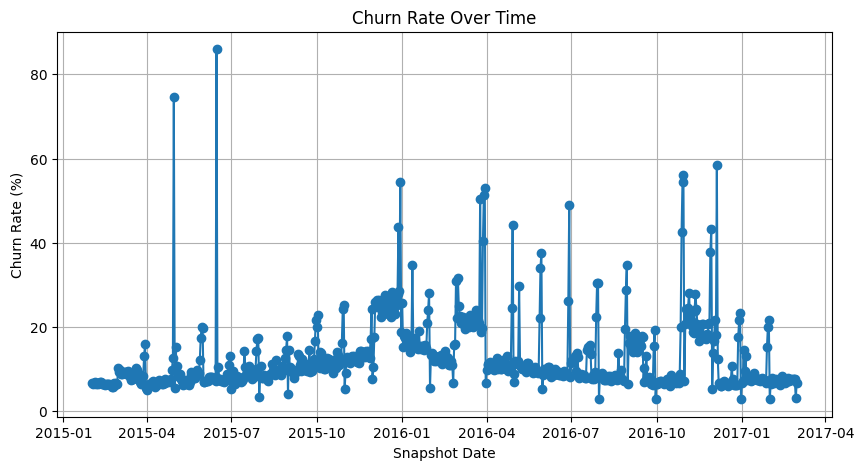

In [14]:
pdf = churn_over_time.toPandas()
plt.figure(figsize=(10,5))
plt.plot(pdf["snapshot_date"], pdf["churn_rate"], marker="o")
plt.title("Churn Rate Over Time")
plt.xlabel("Snapshot Date")
plt.ylabel("Churn Rate (%)")
plt.grid(True)
plt.show()

In [15]:
# ===============================
# 4. User churn frequency
# ===============================
# Some users may appear multiple times; check their churn history
user_churn_stats = (
    result_churn.groupBy("msno")
                .agg(
                    F.count("*").alias("num_snapshots"),
                    F.sum("is_churn").alias("num_churns")
                )
                .withColumn("churn_rate_user", F.round(F.col("num_churns") / F.col("num_snapshots") * 100, 2))
)

user_churn_stats.describe(["num_snapshots", "churn_rate_user"]).show()

[Stage 118:=====================================================> (33 + 1) / 34]

+-------+-----------------+------------------+
|summary|    num_snapshots|   churn_rate_user|
+-------+-----------------+------------------+
|  count|          2313814|           2313814|
|   mean|8.707223225375937|43.966898778378514|
| stddev|8.521127764666767| 44.17846082338543|
|    min|                1|               0.0|
|    max|               71|             100.0|
+-------+-----------------+------------------+



In [16]:
# ===============================
# 5. Correlation sanity check (optional)
# ===============================
# You can calculate correlation between churn and time index if you plan to model temporal effects.
indexed = churn_over_time.withColumn("time_index", F.row_number().over(Window.orderBy("snapshot_date")))
corr_value = indexed.stat.corr("time_index", "churn_rate")
print(f"Correlation between time progression and churn rate: {corr_value:.3f}")

[Stage 131:=====================================================> (33 + 1) / 34]

Correlation between time progression and churn rate: 0.103


## Stop SparkSession

In [17]:
spark.stop()